# Melanoma Classification – Weak Decision Identification and Analysis

This notebook aims to **identify and analyze "weak decision" cases** made by a deep learning model trained to classify skin lesion images as **benign** or **malignant**. It helps to interpret the model’s uncertain predictions and uncover potential areas of improvement in the training data or model architecture.

---

## Dataset

The dataset is organized in the following structure under the Google Drive path:

```
/melonoma_isic/test/
  ├── benign/
  └── malignant/
```

Each folder contains test images labeled accordingly.

---

## Notebook Objectives

### 1. **Model Loading**

* Loads a pre-trained `EfficientNetB0` model from a `.keras` file stored in Google Drive.
* The model has been trained to perform binary classification (benign vs malignant).

### 2. **Test Data Scanning**

* Iterates through test image directories.
* Collects image paths and corresponding ground truth labels.

### 3. **Prediction on Test Set**

* Images are preprocessed and passed to the model **one by one or in batch**.
* For each image, the **predicted probability** (between 0 and 1) is recorded.

### 4. **Weak Decision Identification**

* A prediction is considered a **weak decision** if its probability falls within a low-confidence interval, typically **(0.45, 0.55)**.
* Such cases are stored in a `weak_decisions.csv` file for further analysis.

In [11]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
model_path = "/content/drive/My Drive/melonoma_classification_model/efficientnetb0_melanoma_model.keras"

# Load the model
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
    model.summary() # Display model architecture to verify
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,534,184 (28.74 MB)

 Trainable params: 1,660,257 (6.33 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

 Optimizer params: 3,320,516 (12.67 MB)

In [8]:
# Loading the images as batches
img_arrays = []
true_labels = []
img_paths_clean = []
img_paths = []
labels = []

test_dir = "/content/drive/My Drive/melonoma_isic/test"

# Loading images from the mini test drive dataset (300 test images)

for label_dir in ['benign', 'malignant']:
    class_dir = os.path.join(test_dir, label_dir)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_paths.append(os.path.join(class_dir, fname))
            labels.append(0 if label_dir == 'benign' else 1)

for img_path, label in tqdm(zip(img_paths, labels), total=len(img_paths)):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_arrays.append(img_array)
    true_labels.append(label)
    img_paths_clean.append(img_path)

# Converting to the array data structure
X = np.array(img_arrays)

# Batch prediction
predicted_probs = model.predict(X, batch_size=32).flatten()

# Weak decisions
results = []
for img_path, label, prob in zip(img_paths_clean, true_labels, predicted_probs):
    weak = 0.45 < prob < 0.55
    results.append({
        "image_path": img_path,
        "true_label": label,
        "predicted_prob": prob,
        "weak_decision": weak
    })

100%|██████████| 301/301 [00:00<00:00, 586.52it/s]


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [9]:
df_results = pd.DataFrame(results)
weak_df = df_results[df_results["weak_decision"] == True]
weak_df.to_csv("/content/drive/My Drive/melonoma_isic/weak_decisions.csv", index=False)
print("Weak decision images saved to weak_decisions.csv")

Weak decision images saved to weak_decisions.csv


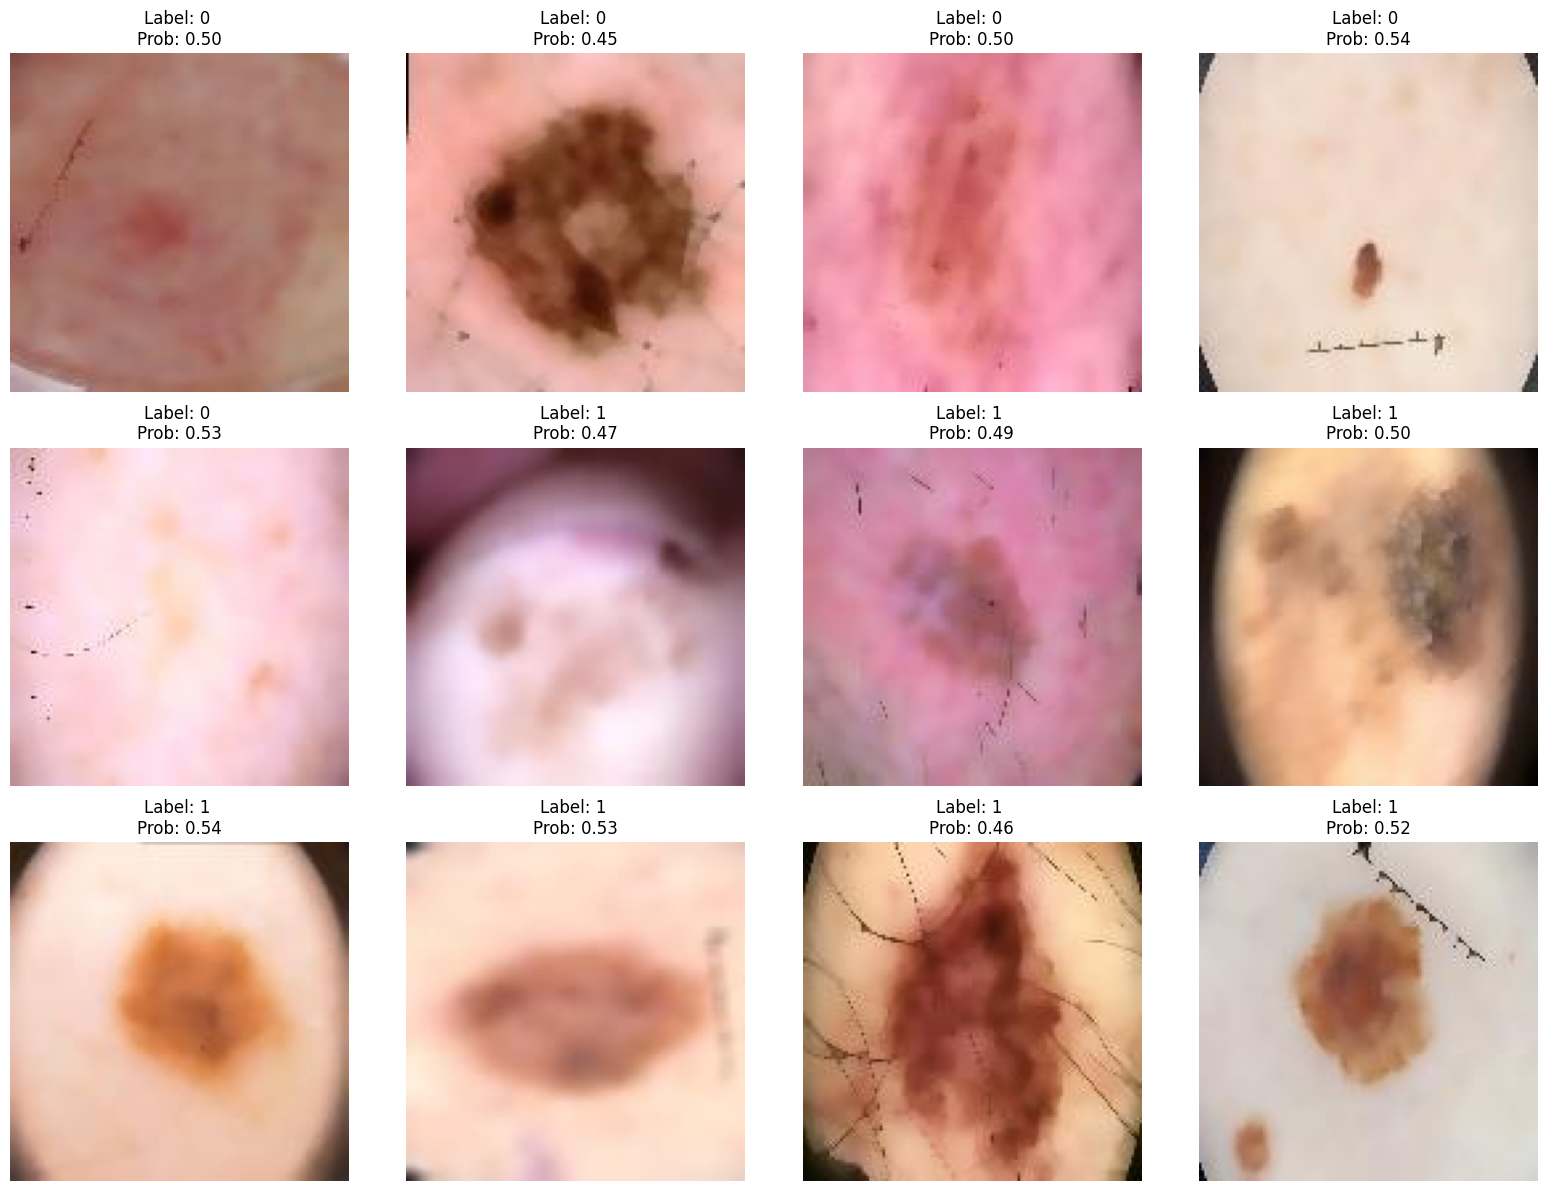

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read it from drive
weak_df = pd.read_csv("/content/drive/My Drive/melonoma_isic/weak_decisions.csv")

# Number of images that will be shown.
N = 12
weak_subset = weak_df.head(N)

# Griding setup for plt lib.
cols = 4
rows = (N + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))

for i, (idx, row) in enumerate(weak_subset.iterrows()):
    img = mpimg.imread(row['image_path'])
    ax = axes[i // cols, i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {row['true_label']} \nProb: {row['predicted_prob']:.2f}")

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


In [12]:
def blur_metric(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()  # low => means blurry

for img_path in weak_df['image_path'].head(5):
    print(f"{img_path}: blur score = {blur_metric(img_path)}")


/content/drive/My Drive/melonoma_isic/test/benign/ISIC_0012155.jpg: blur score = 27.689780578017235
/content/drive/My Drive/melonoma_isic/test/benign/ISIC_0014913.jpg: blur score = 348.96144154295325
/content/drive/My Drive/melonoma_isic/test/benign/ISIC_7953713.jpg: blur score = 35.627986907958984
/content/drive/My Drive/melonoma_isic/test/benign/ISIC_0016050.jpg: blur score = 669.2766139358282
/content/drive/My Drive/melonoma_isic/test/benign/ISIC_8918219.jpg: blur score = 402.07052817568183



# Weak Decision Analysis in Melanoma Classification

This report analyzes the weak decision cases made by a melanoma classification model trained with EfficientNetB0. However, certain images cause the model to make **low-confidence predictions**, also referred to as **weak decisions**.

## Objective

The goal of this analysis is to identify possible causes of weak decisions and improve model reliability by understanding these cases.

## Observations

Some images that the model struggles with exhibit **low visual quality**, especially **blurriness**, which may directly affect prediction confidence. For example:

* **ISIC\_0012155.jpg** has a very low blur score, suggesting that the image is highly blurred, which makes it difficult for the model to extract meaningful features.

On the other hand, several weak decision images are **visually sharp and clear**, such as:

* **ISIC\_0016050.jpg**, which shows that **weak decisions are not always caused by image quality**. Other possible reasons include:

* **Label noise or incorrect annotations**

* **Feature overlap between benign and malignant lesions**

* **Underrepresentation of certain lesion types in the training set**

## Blur Score Table

| Image             | Blur Score | Interpretation               |
| ----------------- | ---------- | ---------------------------- |
| ISIC\_0012155.jpg | 27.68      | Very low – possibly blurry   |
| ISIC\_0014913.jpg | 348.96     | Clear                        |
| ISIC\_7953713.jpg | 35.62      | Low – may be slightly blurry |
| ISIC\_0016050.jpg | 669.27     | Very clear                   |
| ISIC\_8918219.jpg | 402.07     | Clear                        |

## Next Steps
* Perform hyper parameter tuning strategies before the gradcam.
* Perform **Grad-CAM analysis** to examine the model’s attention and focus areas during predictions.
* Investigate **label consistency** and identify potentially mislabeled examples. ( I need oncholog or dermatholog for this purpose (expert knowledge) )

